In [8]:
import os
import pandas as pd

def load_de_data(bhvr_csv_folder):
    """
    Loads manual labeled behavior data from CSV files generated by deepethogram.
    
    Args:
        bhvr_csv_folder: folder containing behavior CSV files
    Returns:
        bhvr_series_dict: dict of dicts of pd.Series
    """
    bhvr_series_dict = {}
    for file_name in os.listdir(bhvr_csv_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(bhvr_csv_folder, file_name)
            data = pd.read_csv(file_path)
            # Remove the first unnamed column (index column).
            data = data.drop(data.columns[[0]], axis=1)
            sess_id = file_name[:-11]
            bhvr_series_dict[sess_id] = {}
            for behavior_name in data.columns:
                bhvr_series_dict[sess_id][behavior_name] = data[behavior_name]
    return bhvr_series_dict


bhvr_csv_folder = '/home/gxj/Desktop/gxj/code/lst_3d_code/manual_labeled_data'
bhvr_series_dict = load_de_data(bhvr_csv_folder)

In [2]:
# Data check.
for annotator in bhvr_series_dict.keys():
    # Check behavior names
    print(annotator, len(bhvr_series_dict[annotator].keys()), list(bhvr_series_dict[annotator].keys()))
    
    # Check empty frames
    df = pd.DataFrame(bhvr_series_dict[annotator])
    frame_sum = df.sum(axis=1)
    empty_frames = (frame_sum == 0).sum()
    bg_1_frames = (bhvr_series_dict[annotator]['background'] == 1).sum()
    print(f"{annotator}: n_frames = {len(df)}, empty_frames = {empty_frames}, bg_1_frames = {bg_1_frames}")
    # Check overlapped frames.
    overlapped_frames = (frame_sum > 1).sum()
    print(f"{annotator}: overlapped_frames = {overlapped_frames}")

lyj 17 ['background', 'freezing', 'escapetonest', 'escapetoother', 'tailratting', 'walking', 'walkingandturning', 'turning', 'rearing', 'wall-rearing', 'up-stretching', 'sniffingground', 'surlingrest', 'rest', 'grooming', 'innest', 'onnest']
lyj: n_frames = 31283, empty_frames = 0, bg_1_frames = 24
lyj: overlapped_frames = 8609
lhh 17 ['background', 'Freezing', 'Escape_to_nest', 'Escape_to_other', 'Tail_ratting', 'Rearing', 'Wall-rearing', 'Up-stretching', 'Sniffing_ground', 'Grooming', 'Curling_rest', 'Rest', 'In_nest', 'On_nest', 'Walking', 'Walking_and_turning', 'Turning']
lhh: n_frames = 31330, empty_frames = 0, bg_1_frames = 0
lhh: overlapped_frames = 8520


In [3]:
import numpy as np
from scipy import interpolate

def resample_bhvr_series_dict(bhvr_series_dict, target_length=None, method='min'):
    """
    Resamples behavior annotation data to ensure all sessions have the same length.
        
    Args:
        bhvr_series_dict: Dictionary containing behavior data for multiple sessions
        target_length: Target length. If None, determined based on the method parameter
        method: 'min' - use shortest length, 'max' - use longest length, 'mean' - use average length
    
    Returns:
        Resampled behavior data dictionary
    """
    # Calculate target length
    if target_length is None:
        lengths = [len(pd.DataFrame(sess_data)) for sess_data in bhvr_series_dict.values()]
        if method == 'min':
            target_length = min(lengths)
        elif method == 'max':
            target_length = max(lengths)
        elif method == 'mean':
            target_length = int(np.mean(lengths))
        print(f"Target resampling length: {target_length}")
    resampled_dict = {}
    for sess_id, sess_data in bhvr_series_dict.items():
        df_original = pd.DataFrame(sess_data)
        original_length = len(df_original)
        if original_length == target_length:
            resampled_dict[sess_id] = sess_data
            print(f"{sess_id}: Length is already {original_length}, no resampling needed")
            continue
        # Create original and target indices
        original_indices = np.arange(original_length)
        target_indices = np.linspace(0, original_length - 1, target_length)
        # Resample each behavior column
        resampled_dict[sess_id] = {}
        for behavior_name in df_original.columns:
            # Use nearest neighbor interpolation (suitable for binary data)
            interp_func = interpolate.interp1d(
                original_indices, 
                df_original[behavior_name].values, 
                kind='nearest',
                fill_value='extrapolate'
            )
            resampled_values = interp_func(target_indices)
            # resampled_values = np.round(resampled_values).astype(int)
            resampled_dict[sess_id][behavior_name] = pd.Series(resampled_values)
        print(f"{sess_id}: {original_length} -> {target_length}")
    return resampled_dict

# Resample lyj data.
bhvr_series_dict_resampled = resample_bhvr_series_dict(bhvr_series_dict, method='max')

Target resampling length: 31330
lyj: 31283 -> 31330
lhh: Length is already 31330, no resampling needed


In [4]:
def standardize_bhvr_names(bhvr_series_dict, bhvr_name_mapping, bhvr_order):
    '''
    Standardizes behavior names across sessions based on a predefined mapping and order.

    Args:
        bhvr_series_dict: Dictionary containing behavior data for multiple sessions

    Returns:
        Standardized behavior data dictionary
    '''
    standardized_dict = {}
    for sess_id, sess_data in bhvr_series_dict.items():
        # Rename behaviors.
        renamed_data = {}
        for old_name, series in sess_data.items():
            if old_name in bhvr_name_mapping:
                new_name = bhvr_name_mapping[old_name]
                if new_name in renamed_data:
                    # If the new name already exists, merge the data (take the maximum value because it's binary data)
                    renamed_data[new_name] = pd.Series(
                        np.maximum(renamed_data[new_name].values, series.values)
                    )
                else:
                    renamed_data[new_name] = series
            else:
                renamed_data[old_name] = series
        # Reorder according to standard list
        ordered_data = {}
        for bhvr_name in bhvr_order:
            if bhvr_name in renamed_data:
                ordered_data[bhvr_name] = renamed_data[bhvr_name]
        standardized_dict[sess_id] = ordered_data
    return standardized_dict

bhvr_name_mapping = {
    # original name -> standard name
    'background': 'background',
    'freezing': 'freezing',
    'Freezing': 'freezing',
    'escapetonest': 'escape_nest',
    'Escape_to_nest': 'escape_nest',
    'escapetoother': 'escape_other',
    'Escape_to_other': 'escape_other',
    'tailratting': 'tail-rattling',
    'Tail_ratting': 'tail-rattling',
    'walking': 'walking',
    'Walking': 'walking',
    'walkingandturning': 'walking_and_turning',
    'Walking_and_turning': 'walking_and_turning',
    'turning': 'turning',
    'Turning': 'turning',
    'rearing': 'rearing',
    'Rearing': 'rearing',
    'wall-rearing': 'rearing_wall',
    'Wall-rearing': 'rearing_wall',
    'up-stretching': 'up-stretching',
    'Up-stretching': 'up-stretching',
    'sniffingground': 'sniffing_ground',
    'Sniffing_ground': 'sniffing_ground',
    'surlingrest': 'curling_then_rest',
    'Curling_rest': 'curling_then_rest',
    'rest': 'rest',
    'Rest': 'rest',
    'grooming': 'grooming',
    'Grooming': 'grooming',
    'innest': 'in-nest',
    'In_nest': 'in-nest',
    'onnest': 'on-nest',
    'On_nest': 'on-nest',
}

bhvr_order = [
    'background',
    'freezing',
    'escape_nest',
    'escape_other',
    'tail-rattling',
    'walking',
    'walking_and_turning',
    'turning',
    'rearing',
    'rearing_wall',
    'up-stretching',
    'sniffing_ground',
    'grooming',
    'curling_then_rest',
    'rest',
    'in-nest',
    'on-nest',
    ]

bhvr_series_dict_std = standardize_bhvr_names(bhvr_series_dict_resampled, bhvr_name_mapping, bhvr_order)

# Check behavior names
for annotator in bhvr_series_dict_std.keys():
    print(annotator, len(bhvr_series_dict_std[annotator].keys()), list(bhvr_series_dict_std[annotator].keys()))


lyj 17 ['background', 'freezing', 'escape_nest', 'escape_other', 'tail-rattling', 'walking', 'walking_and_turning', 'turning', 'rearing', 'rearing_wall', 'up-stretching', 'sniffing_ground', 'grooming', 'curling_then_rest', 'rest', 'in-nest', 'on-nest']
lhh 17 ['background', 'freezing', 'escape_nest', 'escape_other', 'tail-rattling', 'walking', 'walking_and_turning', 'turning', 'rearing', 'rearing_wall', 'up-stretching', 'sniffing_ground', 'grooming', 'curling_then_rest', 'rest', 'in-nest', 'on-nest']


In [5]:
def check_overlapped_frames(bhvr_series_dict, exclude_behaviors=None, verbose=True):
    """
    Check overlapped frames where multiple behaviors are labeled as 1 in the same frame.
    
    Args:
        bhvr_series_dict: Dictionary containing behavior data for multiple sessions
        exclude_behaviors: List of behaviors to exclude, e.g., ['on-nest', 'background']
        verbose: Whether to display detailed information about behavior combinations
    
    Returns:
        Dictionary with overlap statistics for each session
    """
    if exclude_behaviors is None:
        exclude_behaviors = []
    results = {}
    for sess_id, sess_data in bhvr_series_dict.items():
        print(f"Session: {sess_id}")
        # Create DataFrame and exclude specified behaviors
        df = pd.DataFrame(sess_data)
        behaviors_to_check = [b for b in df.columns if b not in exclude_behaviors]
        df_filtered = df[behaviors_to_check]
        # Calculate number of behaviors per frame
        frame_sum = df_filtered.sum(axis=1)
        # Calculate overlap statistics
        overlapped_frames = (frame_sum > 1).sum()
        total_frames = len(df_filtered)
        overlap_ratio = overlapped_frames / total_frames * 100
        print(f"Total frames: {total_frames}")
        print(f"Overlapped frames: {overlapped_frames} ({overlap_ratio:.2f}%)")
        # Detailed overlap analysis
        if verbose and overlapped_frames > 0:
            print(f"Overlap details:")
            # Count frames by number of concurrent behaviors
            overlap_counts = frame_sum.value_counts().sort_index()
            # Find specific overlap combinations (show top 10)
            overlapped_indices = frame_sum[frame_sum > 1].index
            if len(overlapped_indices) > 0:
                overlap_combinations = {}
                for idx in overlapped_indices:
                    active_behaviors = tuple(sorted([b for b in behaviors_to_check if df_filtered.loc[idx, b] == 1]))
                    overlap_combinations[active_behaviors] = overlap_combinations.get(active_behaviors, 0) + 1
                # Sort by frequency
                sorted_combinations = sorted(overlap_combinations.items(), key=lambda x: x[1], reverse=True)
                for combo, count in sorted_combinations[:10]:
                    print(f"  {' + '.join(combo)}: {count} frames")
        results[sess_id] = {
            'overlapped_frames': overlapped_frames,
            'total_frames': total_frames,
            'overlap_ratio': overlap_ratio
        }
    return results

# Check overlapped frames, excluding 'on-nest' and 'in-nest'
results = check_overlapped_frames(bhvr_series_dict_std, exclude_behaviors=['on-nest', 'in-nest'])

Session: lyj
Total frames: 31330
Overlapped frames: 4 (0.01%)
Overlap details:
  sniffing_ground + up-stretching: 1 frames
  rearing + up-stretching: 1 frames
  sniffing_ground + walking: 1 frames
  up-stretching + walking: 1 frames
Session: lhh
Total frames: 31330
Overlapped frames: 5 (0.02%)
Overlap details:
  up-stretching + walking_and_turning: 2 frames
  sniffing_ground + walking: 1 frames
  sniffing_ground + turning: 1 frames
  sniffing_ground + walking_and_turning: 1 frames


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_annotation_confusion_matrix(bhvr_series_dict_std, annotator1, annotator2, exclude_behaviors=None):
    """
    Create confusion matrix showing what annotator2 labeled when annotator1 labeled each behavior.
    
    Args:
        bhvr_series_dict_std: Standardized behavior data dictionary
        annotator1: Name of first annotator (reference)
        annotator2: Name of second annotator (comparison)
        exclude_behaviors: Behaviors to exclude from analysis
    
    Returns:
        confusion_matrix_df: DataFrame with rows=annotator1 behaviors, cols=annotator2 behaviors
    """
    if exclude_behaviors is None:
        exclude_behaviors = []
    data1 = bhvr_series_dict_std[annotator1]
    data2 = bhvr_series_dict_std[annotator2]
    df1 = pd.DataFrame(data1)
    df2 = pd.DataFrame(data2)
    behaviors = [b for b in df1.columns if b not in exclude_behaviors]
    # Initialize confusion matrix
    confusion_mat = pd.DataFrame(0, index=behaviors, columns=behaviors)
    # For each behavior in annotator1
    for bhvr1 in behaviors:
        # Find frames where annotator1 labeled this behavior
        frames_with_bhvr1 = df1[df1[bhvr1] == 1].index
        if len(frames_with_bhvr1) == 0:
            continue
        # Check what annotator2 labeled in these frames
        for bhvr2 in behaviors:
            # Count how many of these frames annotator2 labeled as bhvr2
            count = df2.loc[frames_with_bhvr1, bhvr2].sum()
            confusion_mat.loc[bhvr1, bhvr2] = int(count)
    return confusion_mat

def plot_confusion_heatmap(confusion_mat, annotator1, annotator2, figsize=(10, 9)):
    """
    Plot confusion matrix as heatmap.
    
    Args:
        confusion_mat: Confusion matrix DataFrame
        annotator1: Name of first annotator (y-axis)
        annotator2: Name of second annotator (x-axis)
        figsize: Figure size
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(confusion_mat, annot=True, fmt='g', cmap='YlOrRd', 
                cbar_kws={'label': 'Frame count'}, ax=ax, linewidths=0.5)
    ax.set_title(f'{annotator1} rows × {annotator2} cols')
    ax.set_xlabel(f'{annotator2} labels')
    ax.set_ylabel(f'{annotator1} labels')
    ax.set_xticklabels(confusion_mat.columns, rotation=45, ha='right')
    ax.set_yticklabels(confusion_mat.index, rotation=0)
    plt.tight_layout()
    plt.show()
    return fig

                     background  freezing  escape_nest  escape_other  \
background                    0         0            0             0   
freezing                      0       124            0             0   
escape_nest                   0         0            0             0   
escape_other                  0         0            0             0   
tail-rattling                 0         0            0             0   
walking                       0         0           45             0   
walking_and_turning           0        18            0             0   
turning                       0        54            0             0   
rearing                       0         0            0             0   
rearing_wall                  0         0            0             0   
up-stretching                 0         4           96             0   
sniffing_ground               0         0           40             0   
grooming                      0         0            0          

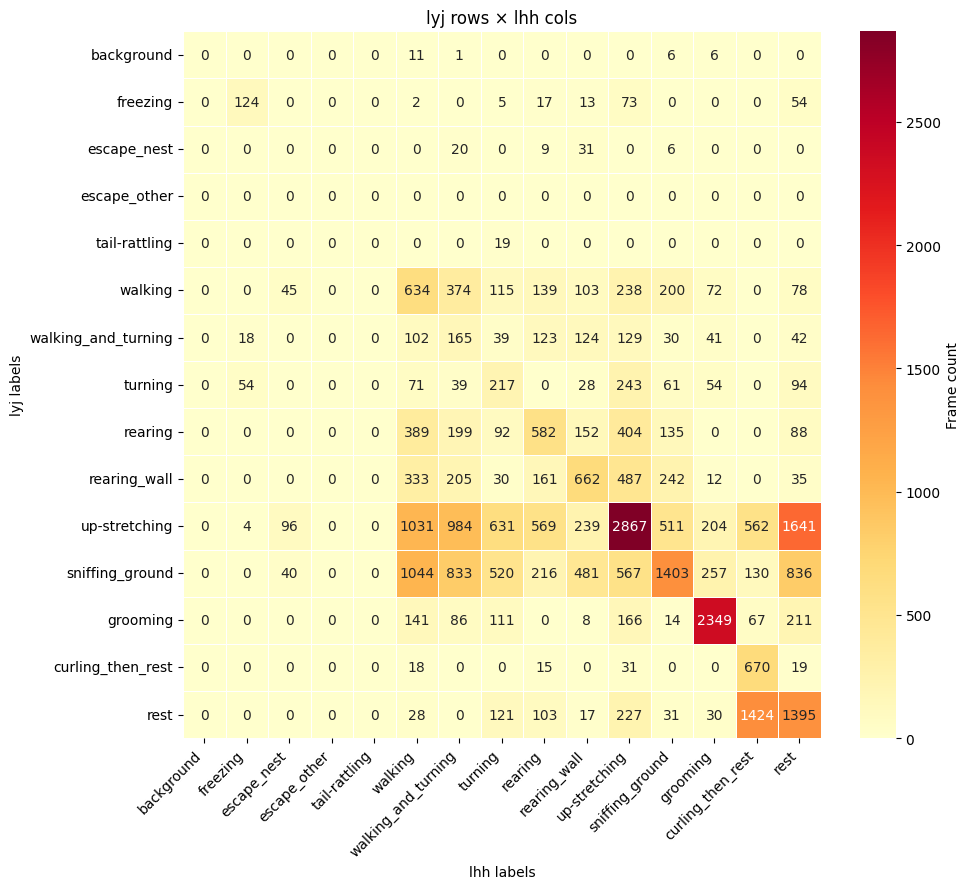

In [17]:
# Create confusion matrix
annotators = list(bhvr_series_dict_std.keys())
confusion_mat = create_annotation_confusion_matrix(
    bhvr_series_dict_std, 
    annotators[0],  # lyj as rows
    annotators[1],  # lhh as columns
    exclude_behaviors=['on-nest', 'in-nest']  # Optional: exclude certain behaviors
)
print(confusion_mat)

# Plot heatmap
fig = plot_confusion_heatmap(confusion_mat, annotators[0], annotators[1])


In [18]:
# Create confusion matrix
confusion_mat = create_annotation_confusion_matrix(
    bhvr_series_dict_std, 
    annotators[0],  # lyj as rows
    annotators[1],  # lhh as columns
    exclude_behaviors=[b for b in bhvr_order if b not in ['in-nest', 'on-nest']]  # Only keep in-nest and on-nest
)
print(confusion_mat)

         in-nest  on-nest
in-nest     8045        0
on-nest        0        2


In [40]:
import cv2
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
import numpy as np

def visualize_bhvr(
    video_path: str,
    bhvr_series_dict: dict,
    sess_id: str,
    frame_range: tuple,
    save_path: str,
    viz_fps: int = 20,
    format: str = None,
    sess_id2: str = None
):
    """
    Visualize behavior annotations on video frames and save output.
    Memory-efficient version using VideoWriter for direct streaming.
    Supports comparing two annotators/sessions on the same video frame.
    
    Args:
        video_path: Path to input video file
        bhvr_series_dict: Dictionary containing behavior data for sessions
        sess_id: First session ID (or single session if no comparison)
        frame_range: Tuple of (start_frame, end_frame, step)
        save_path: Path to save output video
        viz_fps: Frame rate for output video
        format: Output format ('mp4', 'avi', 'gif'). If None, inferred from save_path
        sess_id2: Second session ID for comparison (optional). Will show on same frame.
    """
    import os
    
    start_frame, end_frame, step = frame_range
    
    # ---------- format ----------
    if format is not None:
        fmt = format.lower().lstrip('.')
    else:
        fmt = os.path.splitext(save_path)[1].lower().lstrip('.')
    if fmt == 'jpeg':
        fmt = 'jpg'
    
    # ---------- video reader ----------
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    end_frame = min(end_frame, total_frame)
    
    # ---------- get behavior data ----------
    if sess_id not in bhvr_series_dict:
        raise ValueError(f"Session ID '{sess_id}' not found in bhvr_series_dict")
    
    sess_data = bhvr_series_dict[sess_id]
    bhvr_df = pd.DataFrame(sess_data)
    
    # Get second session data if comparison mode
    sess_data2 = None
    bhvr_df2 = None
    if sess_id2 is not None:
        if sess_id2 not in bhvr_series_dict:
            raise ValueError(f"Session ID '{sess_id2}' not found in bhvr_series_dict")
        sess_data2 = bhvr_series_dict[sess_id2]
        bhvr_df2 = pd.DataFrame(sess_data2)
    
    # ---------- video writer setup ----------
    writer = None
    frames = []  # Only for GIF format
    
    if fmt == 'mp4':
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        writer = cv2.VideoWriter(save_path, fourcc, viz_fps, (frame_width, frame_height))
    elif fmt == 'avi':
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        writer = cv2.VideoWriter(save_path, fourcc, viz_fps, (frame_width, frame_height))
    elif fmt != 'gif':
        raise ValueError(f"Unsupported format: {fmt}. Use 'mp4', 'avi', or 'gif'.")
    
    print("Start rendering & saving...")
    
    # ---------- process frames ----------
    for i, frame_idx in enumerate(range(start_frame, end_frame, step)):
        # Read video frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            print(f"Warning: Cannot read frame {frame_idx}")
            break
        
        if sess_id2:
            # Comparison mode: show both annotators on same frame
            # Get behaviors from both annotators
            active_behaviors1 = []
            if frame_idx < len(bhvr_df):
                for bhvr_name in bhvr_df.columns:
                    if bhvr_df.iloc[frame_idx][bhvr_name] == 1:
                        active_behaviors1.append(bhvr_name)
            
            active_behaviors2 = []
            if frame_idx < len(bhvr_df2):
                for bhvr_name in bhvr_df2.columns:
                    if bhvr_df2.iloc[frame_idx][bhvr_name] == 1:
                        active_behaviors2.append(bhvr_name)
            
            # Draw frame number at top
            cv2.putText(frame, f"Frame: {frame_idx}", 
                        (frame_width // 2 - 100, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                        1.0, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Draw first annotator on the left
            cv2.putText(frame, f"{sess_id}:", 
                        (20, 70), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.8, (255, 255, 0), 2, cv2.LINE_AA)
            
            y_offset = 110
            if active_behaviors1:
                for bhvr in active_behaviors1:
                    cv2.putText(frame, bhvr, 
                                (20, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 
                                0.7, (0, 255, 0), 2, cv2.LINE_AA)
                    y_offset += 30
            else:
                cv2.putText(frame, "No behavior", 
                            (20, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 
                            0.7, (128, 128, 128), 2, cv2.LINE_AA)
            
            # Draw second annotator on the right
            cv2.putText(frame, f"{sess_id2}:", 
                        (frame_width - 200, 70), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.8, (255, 255, 0), 2, cv2.LINE_AA)
            
            y_offset = 110
            if active_behaviors2:
                for bhvr in active_behaviors2:
                    cv2.putText(frame, bhvr, 
                                (frame_width - 200, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 
                                0.7, (0, 255, 255), 2, cv2.LINE_AA)
                    y_offset += 30
            else:
                cv2.putText(frame, "No behavior", 
                            (frame_width - 200, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 
                            0.7, (128, 128, 128), 2, cv2.LINE_AA)
            
        else:
            # Single annotator mode
            active_behaviors = []
            if frame_idx < len(bhvr_df):
                for bhvr_name in bhvr_df.columns:
                    if bhvr_df.iloc[frame_idx][bhvr_name] == 1:
                        active_behaviors.append(bhvr_name)
            
            # Draw frame number (on BGR frame for cv2)
            cv2.putText(frame, f"Frame: {frame_idx}", 
                        (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                        1.5, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Draw active behaviors
            y_offset = 70
            if active_behaviors:
                for bhvr in active_behaviors:
                    cv2.putText(frame, bhvr, 
                                (20, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 
                                1.5, (0, 255, 0), 2, cv2.LINE_AA)
                    y_offset += 40
            else:
                cv2.putText(frame, "No behavior", 
                            (20, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 
                            1.5, (0, 0, 255), 2, cv2.LINE_AA)
        
        # Write frame
        if fmt == 'gif':
            # For GIF, need to collect frames (convert BGR to RGB)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
        else:
            # For MP4/AVI, write directly (BGR format)
            writer.write(frame)
        
        # Progress update
        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1} frames...")
    
    cap.release()
    
    # ---------- finalize output ----------
    if fmt == 'gif':
        print("Creating GIF...")
        clip = ImageSequenceClip(frames, fps=viz_fps)
        clip.write_gif(save_path, logger=None)
    else:
        writer.release()
    
    print(f"Saved to {save_path}")


In [44]:
# Example usage: visualize behavior annotations on video
visualize_bhvr(
    video_path='/home/gxj/Desktop/gxj/lyj_video_test/videos/Camera2 (00K83880156)/Group-A-Mouse-198.avi',
    bhvr_series_dict=bhvr_series_dict,
    sess_id='lyj',
    frame_range=(0, 31330, 2),  # start, end, step
    save_path='/home/gxj/Desktop/gxj/code/lst_3d_code/compare_bhvr_0_1000.mp4',
    viz_fps=10, 
)

Start rendering & saving...
Processed 100 frames...
Processed 200 frames...
Processed 300 frames...
Processed 400 frames...
Processed 500 frames...
Processed 600 frames...
Processed 700 frames...
Processed 800 frames...
Processed 900 frames...
Processed 1000 frames...
Processed 1100 frames...
Processed 1200 frames...
Processed 1300 frames...
Processed 1400 frames...
Processed 1500 frames...
Processed 1600 frames...
Processed 1700 frames...
Processed 1800 frames...
Processed 1900 frames...
Processed 2000 frames...
Processed 2100 frames...
Processed 2200 frames...
Processed 2300 frames...
Processed 2400 frames...
Processed 2500 frames...
Processed 2600 frames...
Processed 2700 frames...
Processed 2800 frames...
Processed 2900 frames...
Processed 3000 frames...
Processed 3100 frames...
Processed 3200 frames...
Processed 3300 frames...
Processed 3400 frames...
Processed 3500 frames...
Processed 3600 frames...
Processed 3700 frames...
Processed 3800 frames...
Processed 3900 frames...
Proces